# Sentiment Analysis by Author


**In this notebook, we will breakdown the sentiment of comments yielded by each author.**

We start by loading a Dataframe of each article and its byline from our Database.

In [1]:
import sqlite3
import pandas as pd

con = sqlite3.connect('nytimes-comments.db')

articles = pd.read_sql_query("SELECT articleID, byline FROM Articles", con)
articles.set_index('articleID')
articles['articleID'].astype(str)
articles.shape

(8699, 2)

We will also load the comments from our Database along with their corresponding article and polarity score.

In [2]:
comments = pd.read_sql_query("SELECT commentID, commentBody, articleID, Polarity FROM commentScore", con)
comments.set_index('articleID')
comments['articleID'].astype(str)
comments.shape

(2047446, 4)

In the next cell, we create a dictionary mapping each author to the articles that they worked on. This requires a *LOT* of cleaning -- many articles have multiple authors, authors names often have 'non-english' characters, and different author formats are used.

The majority of the bylines take the form:

By KAI WOMBACHER, EMILY JAEKLE, and CYNTHIA VU

As a result, after cleaning, we use groupings of captial letters to pull-out the authors

In [3]:
import re
author_article_dict = {}
#Iterate through the Articles Dataframe
for index, row in articles.iterrows():
    author = row['byline']
    article = row['articleID']
    # The majority of the entries
    if re.search("^By ", author):
        # Cleaning
        author = re.sub("^By ", '', author)
        author = re.sub("-", ' ', author)
        author = re.sub("\.", '', author)
        author = re.sub("\'", '', author)
        author = re.sub("É", 'E', author)
        author = re.sub("È", 'E', author)
        author = re.sub("Ñ", 'N', author)
        author = re.sub("À", 'A', author)
        author = re.sub("Á", 'A', author)
        author = re.sub("Ạ", 'A', author)
        author = re.sub("Í", 'I', author)
        author = re.sub("Ö", 'O', author)
        if re.search('Mc', author):
            author = re.sub('c', 'C', author)
        if re.search('Mac', author):
            author = re.sub('ac', 'AC', author)
        if re.search('MD', author):
            author = re.sub('MD', '', author)
        if re.search('de', author):
            author = re.sub('de', 'DE', author)
        if re.search('De', author):
            author = re.sub('De', 'DE', author)
        if re.search('la', author):
            author = re.sub('la', 'LA', author)
        if re.search('La', author):
            author = re.sub('La', 'LA', author)
        if re.search('Jr', author):
            author = re.sub('Jr', 'JR', author)
        # Select Captial letter and space groupings 
        author_matches = re.findall("[A-Z ]+", author)
        #print(author_matches)
        for author in author_matches:
            #Strip and put into dict
            if author.isspace():
                continue
            else:
                author_cleaned = author.strip()
            if not author_cleaned in author_article_dict:
                author_article_dict[author_cleaned] = [article]
            else:
                author_article_dict[author_cleaned].append(article)
    # Exceptions or entries that do not follow the default for
    else:
        author = re.sub("\.", '', author)
        author_matches = re.findall("[A-Z ]{3,}", author)
        for author in author_matches:
            if author == ' ':
                continue
            else:
                if re.search('BY', author):
                    author = re.sub('.+ BY ', '', author)
                #Strip and put into dict
                author_cleaned = author.strip()
                if not author_cleaned in author_article_dict:
                    author_article_dict[author_cleaned] = [article]
                else:
                    author_article_dict[author_cleaned].append(article)
                    
#There are two different forms for the name of the author 'A O SCOTT': "AO SCOTT" & "A O SCOTT"                    
author_article_dict['A O SCOTT'].extend(author_article_dict['AO SCOTT'])
author_article_dict.pop('AO SCOTT')

print(len(author_article_dict))
authors = author_article_dict.keys()
print(authors)

2216
dict_keys(['KEN BELSON', 'UNKNOWN', 'MANOHLA DARGIS', 'ALEXANDRA S LEVINE', 'BONNIE TSUI', 'CAITLIN LOVINGER', 'KATHERINE SCHULTEN', 'IOAN GRILLO', 'GAIL COLLINS', 'CHARLES M BLOW', 'THOMAS B EDSALL', 'CAROLINE CROSSON GILPIN', 'BROOK LARMER', 'FRANCIS LAM', 'ZIAD RESLAN', 'MARK LANDLER', 'LAURIE GOODSTEIN', 'CONSTANCE MALCOLM', 'STEPHANIE STROM', 'A O SCOTT', 'DAVID W DUNLAP', 'PETER BAKER', 'DAVID E SANGER', 'NEIL IRWIN', 'ERIC ASIMOV', 'LIGAYA MISHAN', 'ANGELINA JOLIE', 'NICHOLAS BAKALAR', 'LIZ SPAYD', 'BEN KENIGSBERG', 'ROGER COHEN', 'CATHERINE SAINT LOUIS', 'YITTA HALBERSTAM', 'THE EDITORIAL BOARD', 'FARAH STOCKMAN', 'ALEC MACGILLIS', 'TIMOTHY EGAN', 'PAUL KRUGMAN', 'DAVID BROOKS', 'JOHN HODGMAN', 'MATTHEW ZAPRUDER', 'PATRICIA LEIGH BROWN', 'DANA GOLDSTEIN', 'ADAM NOSSITER', 'MICHAEL GONCHAR', 'MICHAEL BARBARO', 'SARA ACKERMAN', 'GINIA BELLAFANTE', 'GRETCHEN REYNOLDS', 'JEN A MILLER', 'MAGGIE HASSAN', 'EVAN GERSHKOVICH', 'EMILY HANFORD', 'DAVID TANIS', 'BEN PROTESS', 'JULIE H

We also want to create a Dataframe of each articleID and its number of comments

In [4]:
article_comment_count =comments.groupby('articleID')['commentID'].nunique()

Putting all of our above Data together, we create a Dataframe of Authors and their Summed Sentiment Score, the Number of Articles they took part in, and the total Number of Comments they received.

In [5]:
import pandas as pd
authors_scores = pd.DataFrame(index = authors)
scores = []
comment_counts = []
article_counts = []

articles_score = comments.groupby('articleID')['Polarity'].sum()
for author in authors:
    author_score = 0
    comment_count = 0
    article_count = 0
    for articleID in author_article_dict[author]:
        author_score += articles_score[articleID]
        comment_count += article_comment_count[articleID]
        article_count += 1
    scores.append(author_score/article_count)
    comment_counts.append(comment_count)
    article_counts.append(article_count)


authors_scores['Score'] = scores
authors_scores['Number_of_Comments'] = comment_counts
authors_scores['Number_of_Articles'] = article_counts
authors_scores.index.name = 'Author'
authors_scores

,Score,Number_of_Comments,Number_of_Articles
Author,,,
KEN BELSON,7.905240,1125,11
UNKNOWN,16.918194,11813,67
MANOHLA DARGIS,5.661037,691,16
ALEXANDRA S LEVINE,2.302097,1455,88
BONNIE TSUI,15.060359,654,3
CAITLIN LOVINGER,10.516776,5352,70
KATHERINE SCHULTEN,4.328075,3985,97
IOAN GRILLO,23.168074,928,3
GAIL COLLINS,39.205649,36194,70


## Visualizations

We can now Visualize the authors with the highest Summed Sentiment Scores. It is important to note that these scores are not normalized by the number of comments - the sentiment scores for each author are only normalized by the number of articles.

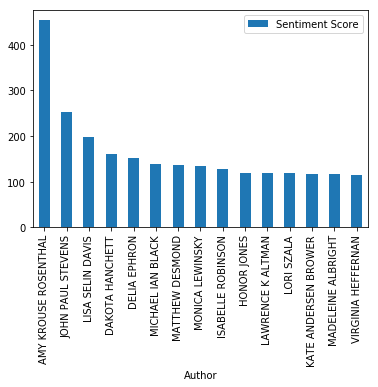

In [78]:
import matplotlib.pyplot as plt

top_10 = authors_scores.nlargest(n = 15, columns = 'Score')
top_10['Score'].plot(kind='bar')
L = plt.legend()
L.get_texts()[0].set_text('Sentiment Score')
plt.show()

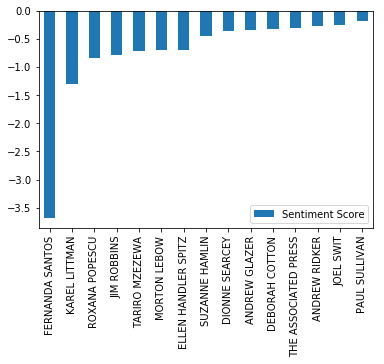

In [46]:
import matplotlib.pyplot as plt

bottom_10 = authors_scores.nsmallest(n = 15, columns = 'Score')
bottom_10['Score'].plot(kind='bar')
L = plt.legend()
L.get_texts()[0].set_text('Sentiment Score')
plt.show()

In [7]:
import plotly.plotly as py

authors_scores

fig = {
    'data': [
        {
            'x': authors_scores.Number_of_Comments, 
            'y': authors_scores.Score, 
            'text': authors_scores.index, 
            'mode': 'markers',
        },
    ],
    'layout': {
        'title': 'Sentiment Analysis by Author',
        'xaxis': {'title': 'Number of Comments',},
        'yaxis': {'title': "Summed Sentiment Score"}
    }
}

py.iplot(fig, filename='scatter_one', sharing='public')

In [69]:
author_article_dict['AMY KROUSE ROSENTHAL']

['58b93eac95d0e024902fd502', '58b93eab7c459f2525d1f9b7']

In [72]:
comments[comments['articleID'] == '58b93eac95d0e024902fd502']

,commentID,commentBody,articleID,Polarity
1984229,21849175.0,"hi, Amy has been lucky, incidently so have I, ...",58b93eac95d0e024902fd502,0.213228
1984230,21831894.0,Oh my goodness....❤️,58b93eac95d0e024902fd502,0.000000
1984231,21830147.0,"those of us with terminal cancer, for sure, un...",58b93eac95d0e024902fd502,0.150000
1984232,21825894.0,"I don't know who I'm writing this too, but tha...",58b93eac95d0e024902fd502,0.000000
1984233,21824158.0,Here writ large is the very best example of de...,58b93eac95d0e024902fd502,0.519048
1984234,21820194.0,Amy is such an incredible writer an inspiratio...,58b93eac95d0e024902fd502,0.317708
1984235,21818945.0,There is no greater gift than to Love oneself ...,58b93eac95d0e024902fd502,0.264286
1984236,21818871.0,My heart goes to Amy and her wonderful family ...,58b93eac95d0e024902fd502,0.500000
1984237,21816443.0,This is beautiful. It is such a great reminder...,58b93eac95d0e024902fd502,0.412500
1984238,21814831.0,I submitted a heart felt response to the artic...,58b93eac95d0e024902fd502,0.000000


In [8]:
import plotly.plotly as py
import plotly.graph_objs as go

authors_scores
mean_score = authors_scores[['Score']].mean()
mean_comart = ((authors_scores['Number_of_Comments'])/(authors_scores['Number_of_Articles'])).mean()

trace1 = go.Scatter(
    x=[mean_score, mean_score, mean_score],
    y=[0, 3000],
    name='Mean Comment Scores'
)

trace2 = go.Scatter(
    x=[0, 500],
    y=[mean_comart, mean_comart, mean_comart],
    name='Mean Comment per Article Value'
)

fig = {
    'data': [
        {
            'x': authors_scores.Score, 
            'y': (authors_scores.Number_of_Comments)/(authors_scores.Number_of_Articles), 
            'text': authors_scores.index, 
            'mode': 'markers'
        }, trace1, trace2
    ],
    'layout': {
        'title': 'Polarity Analysis by Author',
        'xaxis': {'title': "Summed Sentiment Score",},
        'yaxis': {'title': 'Number of Comments per Article'}
    }
}

py.iplot(fig, filename='scatter_two', sharing='public')